In [18]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [78]:
import mne
import os
import matplotlib
import numpy as np

In [ ]:
#Find all the files in the data/Alken-29March/ folder with .dat extension  
files = [f for f in os.listdir('data/Alken-29March/') if f.endswith('.dat')]

#Sort the files in ascending order
files.sort()

#Removes the test file
files.pop()

#Read the files into a list of raw objects
raws = [mne.io.read_raw_curry('data/Alken-29March/' + f, preload=True) for f in files]

#For each raw object, select only the EEG channels Pz,POz,PO3,PO4,PO7,PO8,Oz,O1,O2
raws = [raw.pick_channels(['POz','PO3','PO4','PO7','PO8','Oz','O1','O2']) for raw in raws]

#Setting the sampling frequency to 2000
fs = 2000


In [ ]:
#For each raw object plot the data for each channel. Label the graph according to the filename of the raw object. Also only include channels POz,Pz,Oz,O1,O2,PO3,PO4,PO7,PO8
for raw in raws:
    #index of raw in raws
    i = raws.index(raw)
    raw.plot(scalings='auto', title=files[i], show=True, block=True)
    matplotlib.pyplot.show()


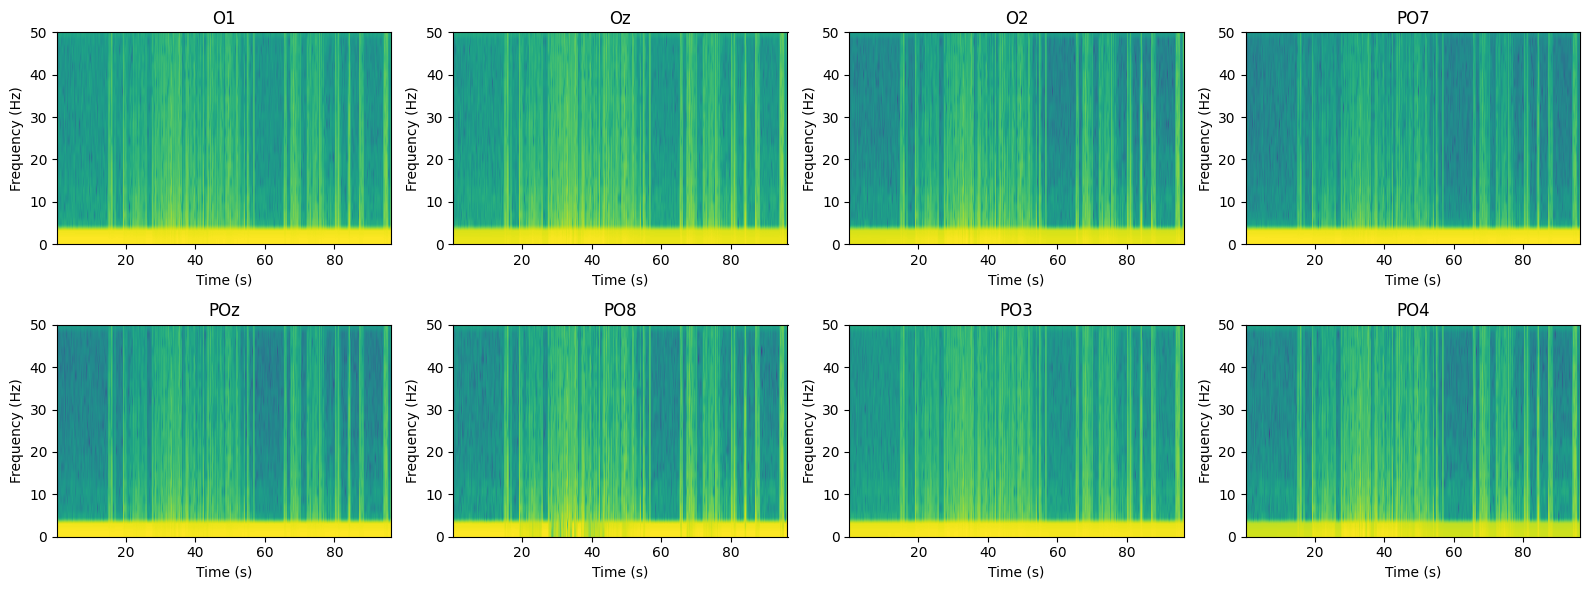

In [116]:
eeg = raws[1].get_data()
fig, axs = matplotlib.pyplot.subplots(2, 4, figsize=(16, 6))
for i in range(0, 8):
    axs[i // 4, i % 4].specgram(eeg[i, :], Fs=fs, NFFT=1024, noverlap=512)
    axs[i // 4, i % 4].set_title(raws[1].ch_names[i])
    axs[i // 4, i % 4].set_ylim(0, 50) # set the maximum frequency range to 50Hz
    axs[i // 4, i % 4].set_xlabel('Time (s)')
    axs[i // 4, i % 4].set_ylabel('Frequency (Hz)')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
